In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # GPU 메모리 제한 설정 (필요에 따라 수정 가능)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
        )
        print("GPU 설정 완료")
    except RuntimeError as e:
        print(e)

GPU 설정 완료


- 4 개의 클래스 분류
- Early Stopping 적용
- 128 * 128
- relu 층 하나 추가
- batch 8
- 50 epochs max
- 증강 추가
- 레어어 추가, Batch Normalization, Global Average Pooling
- ExponentialDecay

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import os
import shutil

# 데이터 경
train_dir = '../../../Dataset_4_class/Train'
test_dir = '../../../Dataset_4_class/Test'

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  
    batch_size=8,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),  
    batch_size=8,
    class_mode='categorical'
)

from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(train_generator.num_classes, activation='softmax')
])

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9
)

optimizer = Adam(learning_rate=lr_schedule)

# 모델 컴파일
model.compile(
    optimizer=optimizer,  
    loss='categorical_crossentropy',  
    metrics=['accuracy']  
)

# Early Stopping 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 기준으로 삼을 값
    patience=5,          # 성능 개선이 없을 때 몇 번의 에포크를 기다릴지
    restore_best_weights=True  # 최상의 가중치 복원
)

# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,  # 초기에는 충분히 큰 값으로 설정
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping]
)

# 모델 저장
model.save('cnn_4_class_2_6.h5')
print("모델 저장 완료")


Found 33536 images belonging to 4 classes.
Found 5851 images belonging to 4 classes.
Epoch 1/50
4192/4192 [==============================] - 483s 115ms/step - loss: 0.6123 - accuracy: 0.7590 - val_loss: 0.2525 - val_accuracy: 0.8962
Epoch 2/50
4192/4192 [==============================] - 502s 120ms/step - loss: 0.3900 - accuracy: 0.8562 - val_loss: 0.1183 - val_accuracy: 0.9554
Epoch 3/50
4192/4192 [==============================] - 476s 113ms/step - loss: 0.3123 - accuracy: 0.8880 - val_loss: 0.0922 - val_accuracy: 0.9651
Epoch 4/50
4192/4192 [==============================] - 473s 113ms/step - loss: 0.2628 - accuracy: 0.9063 - val_loss: 0.0738 - val_accuracy: 0.9771
Epoch 5/50
4192/4192 [==============================] - 514s 123ms/step - loss: 0.2330 - accuracy: 0.9187 - val_loss: 0.0519 - val_accuracy: 0.9814
Epoch 6/50
4192/4192 [==============================] - 551s 131ms/step - loss: 0.2085 - accuracy: 0.9275 - val_loss: 0.0637 - val_accuracy: 0.9790
Epoch 7/50
4192/4192 [=====

In [3]:
print("클래스 인덱스:", train_generator.class_indices)


클래스 인덱스: {'BUS': 0, 'Bike': 1, 'Common': 2, 'Truck': 3}


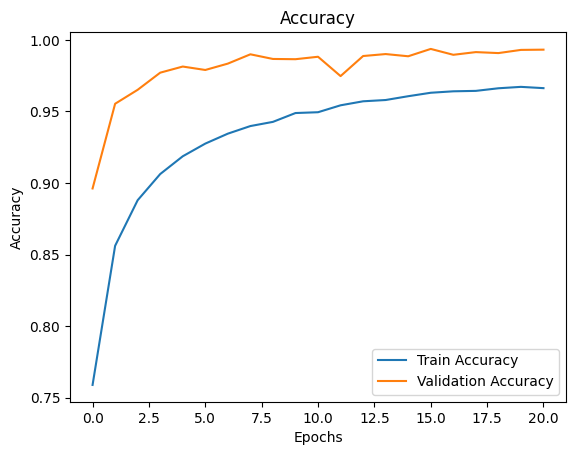

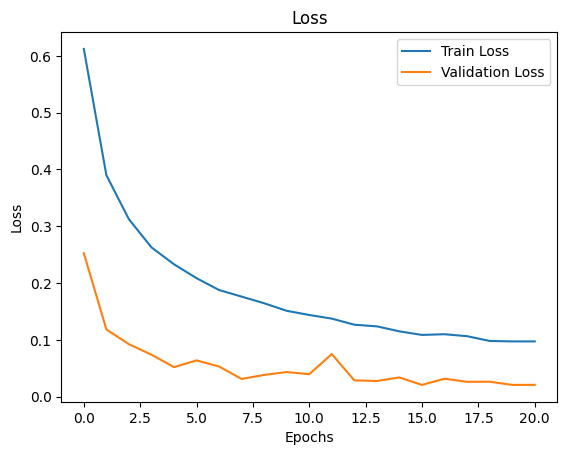

In [4]:
import matplotlib.pyplot as plt

# 학습 및 검증 정확도 그래프
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("cnn_4_class_2_6_Accuracy_Epochs")
plt.show()

# 학습 및 검증 손실 그래프
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("cnn_4_class_2_6_Loss_Epochs")
plt.show()

Found 5851 images belonging to 4 classes.
1/1 [==============================] - 0s 21ms/step


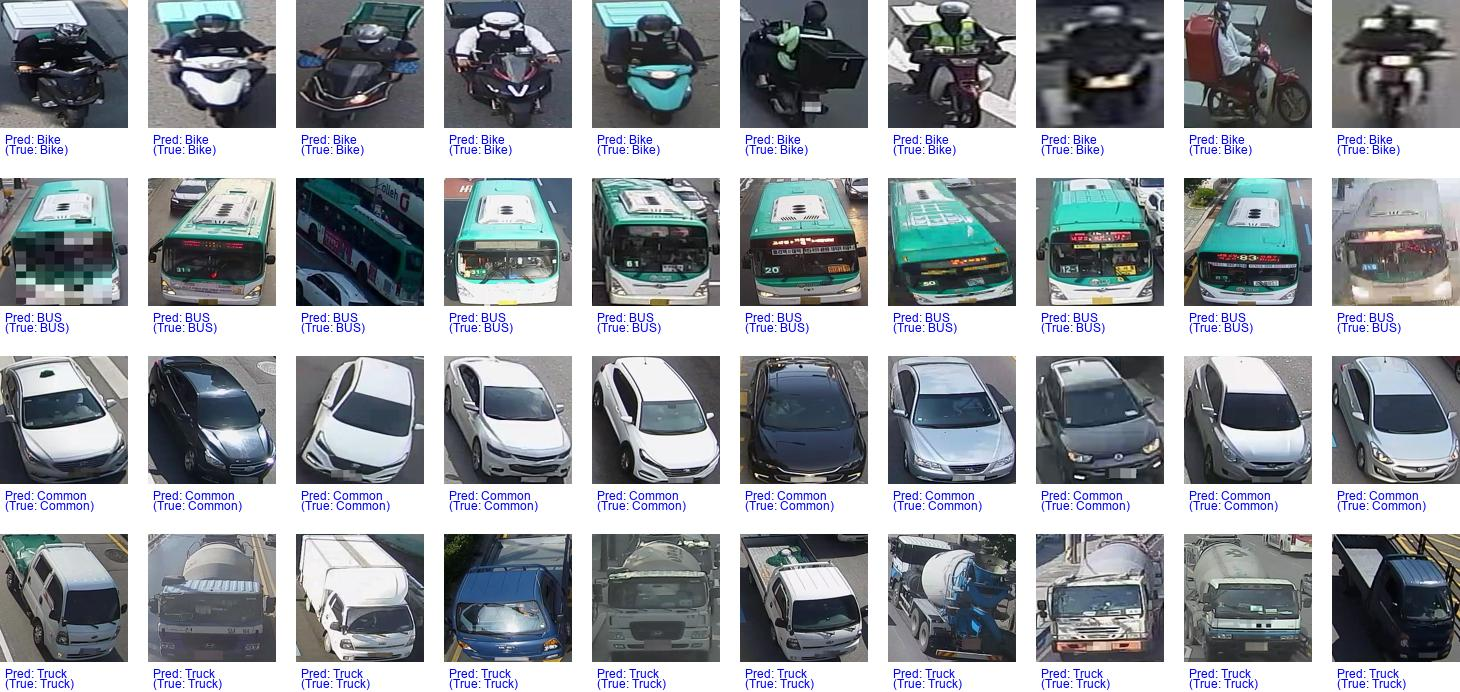

In [5]:
import os
import random
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# 모델 로드
model = load_model('cnn_4_class_2_6.h5')

# 데이터 경로와 클래스 설정
test_dir = '../../../Dataset_4_class/Test'

# 인덱스가 파일시스템 정렬에 변동되는 문제 개선
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()
test_generator = datagen.flow_from_directory(test_dir)
class_indices = test_generator.class_indices

index_to_class = {v: k for k, v in class_indices.items()}  # 인덱스 -> 클래스 이름 매핑

# 모델 입력 크기
img_size = (128, 128)  # 모델이 요구하는 입력 크기

# 여백 설정
padding = 20  # 이미지 간 여백 (픽셀 단위)
text_height = 30  # 텍스트 영역 높이

# 랜덤 샘플 테스트
results = []
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if not os.path.isdir(class_path):  # 디렉토리인지 확인
        continue
    
    # 해당 클래스 폴더의 모든 파일 가져오기
    images = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    
    # 랜덤으로 10개 선택 (이미지가 10개 미만이면 모두 선택)
    sampled_images = random.sample(images, min(10, len(images)))
    
    # 예측 수행
    for image_path in sampled_images:
        # 이미지 로드 및 전처리
        img = load_img(image_path, target_size=img_size, color_mode='rgb')
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # 예측
        predictions = model.predict(img_array)
        predicted_index = np.argmax(predictions, axis=1)[0]
        predicted_class = index_to_class[predicted_index]

        # 결과 저장
        results.append({
            'image': image_path,
            'predicted_class': predicted_class,
            'true_class': class_name
        })

# 이미지 합치기
num_images_per_row = 10  # 가로에 표시할 이미지 수
output_width = img_size[0] * num_images_per_row + padding * (num_images_per_row - 1)  # 가로 크기
num_rows = (len(results) + num_images_per_row - 1) // num_images_per_row  # 전체 행 수
output_height = (img_size[1] + text_height) * num_rows + padding * (num_rows - 1)  # 세로 크기
output_image = Image.new("RGB", (output_width, output_height), "white")

# 폰트 설정 (기본 폰트 사용)
try:
    font_path = "C:/Windows/Fonts/arial.ttf"  # Windows 시스템 기본 폰트 경로
    font = ImageFont.truetype(font_path, size=12)
except OSError:
    print("Custom font not found. Using default font.")
    font = ImageFont.load_default()

draw = ImageDraw.Draw(output_image)

# 각 이미지를 합친다
x_offset, y_offset = 0, 0
for i, result in enumerate(results):
    # 이미지 열기
    img = Image.open(result['image']).resize(img_size)
    output_image.paste(img, (x_offset, y_offset))
    
    # 예측 텍스트 추가 (이미지 아래, 개행 포함)
    text = f"Pred: {result['predicted_class']}\n(True: {result['true_class']})"
    text_color = "blue" if result['predicted_class'] == result['true_class'] else "red"  # 색상 결정
    
    # 여러 줄 텍스트 작성
    text_x = x_offset + 5
    text_y = y_offset + img_size[1] + 5  # 이미지 바로 아래
    for line in text.split("\n"):  # 개행 기준으로 나누어 작성
        draw.text((text_x, text_y), line, fill=text_color, font=font)
        text_y += 10  # 줄 간격 추가 (폰트 크기 고려)

    # 다음 위치로 이동
    x_offset += img_size[0] + padding
    if x_offset >= output_width:  # 한 줄이 가득 찼을 경우
        x_offset = 0
        y_offset += img_size[1] + text_height + padding

output_image_path = "cnn_4_class_2_6_combined_predictions_colored_text.jpg"
output_image.save(output_image_path)
output_image = Image.open(output_image_path)
display(output_image)